# Kununu Web Scraping

#### Historical Review comparison

Populating the interactive namespace from numpy and matplotlib


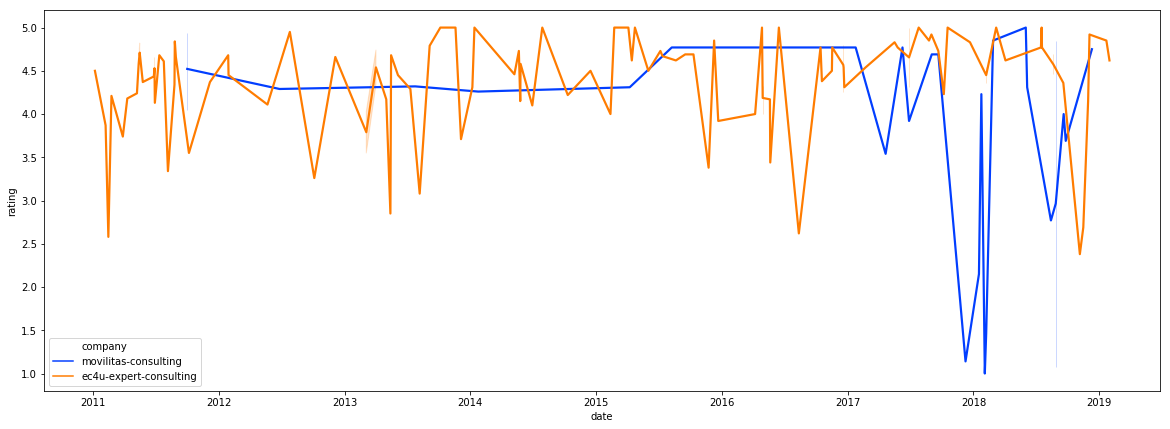

In [16]:
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 7) # set all figures to be size (width, height)
df = pd.read_json('kununu_result.json', lines=True)
sns.lineplot(data = df , x="date", y="rating",
             hue = 'company',
             palette=sns.color_palette('bright', n_colors=2),
             linewidth=2.2)

#### Definition Pipeline

In [1]:
import json

class FirstPipeline(object):
    
    def open_spider(self, spider):
        self.file = open('kununu_result.json', 'w') # JSON lines (.jl) files
        #JSON lines is a text file format where each line is a single json encoded item.

    def process_item(self, item, spider):
        item['rating'] = item['rating'].strip()
        item['rating'] = float(item['rating'].replace(',', "."))

        item['date'] = item['date'].replace('Jan. ', "01.")
        item['date'] = item['date'].replace('Feb. ', "02.")
        item['date'] = item['date'].replace('März', "03.")
        item['date'] = item['date'].replace('Apr. ', "04.")
        item['date'] = item['date'].replace('Mai ', "05.")
        item['date'] = item['date'].replace('Juni ', "06.")
        item['date'] = item['date'].replace('Juli ', "07.")
        item['date'] = item['date'].replace('Aug. ', "08.")
        item['date'] = item['date'].replace('Sep. ', "09.")
        item['date'] = item['date'].replace('Okt. ', "10.")
        item['date'] = item['date'].replace('Nov. ', "11.")
        item['date'] = item['date'].replace('Dez. ', "12.")
        item['date'] = item['date'].replace(' ', "")
        
        # Extract Company Name from URL and define unique company ids
        item['company'] = item['url'].split("/de/")[1].split("/")[0]
        item['company_id'] = 1 if item['company']  == 'movilitas-consulting' else _
        item['company_id'] = 2 if item['company']  == 'ec4u-expert-consulting' else 3
        
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)      
        return item

    def close_spider(self, spider):
        self.file.close()

#### Definition KununuSpider - Class

In [2]:
import scrapy
import logging


class KununuSpider(scrapy.Spider):
    name = "kununu"
    allowed_domains = ["kununu.com"]

    custom_settings = {
        'LOG_LEVEL': logging.WARNING,                             # only show warnings 
        'ITEM_PIPELINES': {'__main__.FirstPipeline': 1}           # Activate pipeline
    }

    # Reduce Log-Level of some Loggers to avoid "spam" messages in Command line
    def __init__(self, *args, **kwargs):
        logger = logging.getLogger('scrapy.core.scraper')
        logger.setLevel(logging.INFO)
        logger2 = logging.getLogger('scrapy.core.engine')
        logger2.setLevel(logging.INFO)
        logger3 = logging.getLogger('scrapy.middleware')
        logger3.setLevel(logging.WARNING)
        logger4 = logging.getLogger('kununu')
        logger4.setLevel(logging.WARNING)
        super().__init__(*args, **kwargs)

    def start_requests(self):
        yield scrapy.Request('https://www.kununu.com/de/movilitas-consulting/kommentare', self.parse)
        yield scrapy.Request('https://www.kununu.com/de/ec4u-expert-consulting/kommentare', self.parse)

    def parse(self, response):
        print("Aktuelle Seite : {}".format(response.url))
        review_list = response.css('article.company-profile-review')
        for elem in review_list:
                    item = {
                               'url': response.url,
                               'date': elem.css('span::text')[1].extract(),
                               'title': elem.css('a::text')[0].extract(),
                               'rating': elem.css('div.tile-heading::text')[0].extract()
                            }
                    yield item

        next_page_url = response.css('a.btn.btn-default.btn-block::attr(href)') # does this attribute exist at all or is returned an empty list?
        if next_page_url:
           next_page_url = next_page_url[0].extract()
           next_page_url = response.urljoin(next_page_url)
           yield scrapy.Request(url=next_page_url, callback = self.parse)
        else:
            self.log('');self.log('');self.log('');self.log('');
            self.log('Last page reached: ' + response.url)
            self.log('Last page contained {} item(s)'.format(len(review_list)))
            self.log('');self.log('');self.log('');self.log('');self.log('');


#### Execution CrawlerProcess

In [3]:
from scrapy.crawler import CrawlerProcess
process = CrawlerProcess({
    'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
})

process.crawl(KununuSpider)
process.start()

2019-02-23 16:56:11 [scrapy.utils.log] INFO: Scrapy 1.5.2 started (bot: scrapybot)
2019-02-23 16:56:11 [scrapy.utils.log] INFO: Versions: lxml 4.3.0.0, libxml2 2.9.9, cssselect 1.0.3, parsel 1.5.1, w3lib 1.20.0, Twisted 18.9.0, Python 3.7.2 (default, Feb 11 2019, 14:11:50) [MSC v.1915 64 bit (AMD64)], pyOpenSSL 19.0.0 (OpenSSL 1.1.1a  20 Nov 2018), cryptography 2.5, Platform Windows-10-10.0.17134-SP0
2019-02-23 16:56:11 [scrapy.crawler] INFO: Overridden settings: {'LOG_LEVEL': 30, 'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}


Aktuelle Seite : https://www.kununu.com/de/movilitas-consulting/kommentare
Aktuelle Seite : https://www.kununu.com/de/movilitas-consulting/kommentare/2
Aktuelle Seite : https://www.kununu.com/de/ec4u-expert-consulting/kommentare
Aktuelle Seite : https://www.kununu.com/de/movilitas-consulting/kommentare/3
Aktuelle Seite : https://www.kununu.com/de/ec4u-expert-consulting/kommentare/2
Aktuelle Seite : https://www.kununu.com/de/movilitas-consulting/kommentare/4
Aktuelle Seite : https://www.kununu.com/de/ec4u-expert-consulting/kommentare/3
Aktuelle Seite : https://www.kununu.com/de/ec4u-expert-consulting/kommentare/4
Aktuelle Seite : https://www.kununu.com/de/ec4u-expert-consulting/kommentare/5
Aktuelle Seite : https://www.kununu.com/de/ec4u-expert-consulting/kommentare/6
Aktuelle Seite : https://www.kununu.com/de/ec4u-expert-consulting/kommentare/7
Aktuelle Seite : https://www.kununu.com/de/ec4u-expert-consulting/kommentare/8
Aktuelle Seite : https://www.kununu.com/de/ec4u-expert-consultin

## Visualization

In [4]:
import pandas as pd
import seaborn as sns

df = pd.read_json('kununu_result.json', lines=True)
print(df.dtypes);print(); 
print('Number of records: {}'.format(df.date.count()))
df.head()

company               object
company_id             int64
date          datetime64[ns]
rating               float64
title                 object
url                   object
dtype: object

Number of records: 153


,company,company_id,date,rating,title,url
0,movilitas-consulting,3,2018-12-11,4.75,"Ein Unternehmen, das die Messlatte sehr hoch g...",https://www.kununu.com/de/movilitas-consulting...
1,movilitas-consulting,3,2018-09-20,4.00,Sehr guter AG mit viel Potential und tollen MA,https://www.kununu.com/de/movilitas-consulting...
2,movilitas-consulting,3,2018-08-28,1.08,"Welcome to Movilitas, where the devil wears Pr...",https://www.kununu.com/de/movilitas-consulting...
3,movilitas-consulting,3,2018-08-28,4.85,Eine Empfehlung!,https://www.kununu.com/de/movilitas-consulting...
4,movilitas-consulting,3,2018-08-14,2.77,Leider wenig Benefits für ein mittelmäßiges Ge...,https://www.kununu.com/de/movilitas-consulting...


### Plot as-is

2019-02-23 16:56:29 [py.warnings] WARNING: C:\Users\The Woops\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)



Populating the interactive namespace from numpy and matplotlib


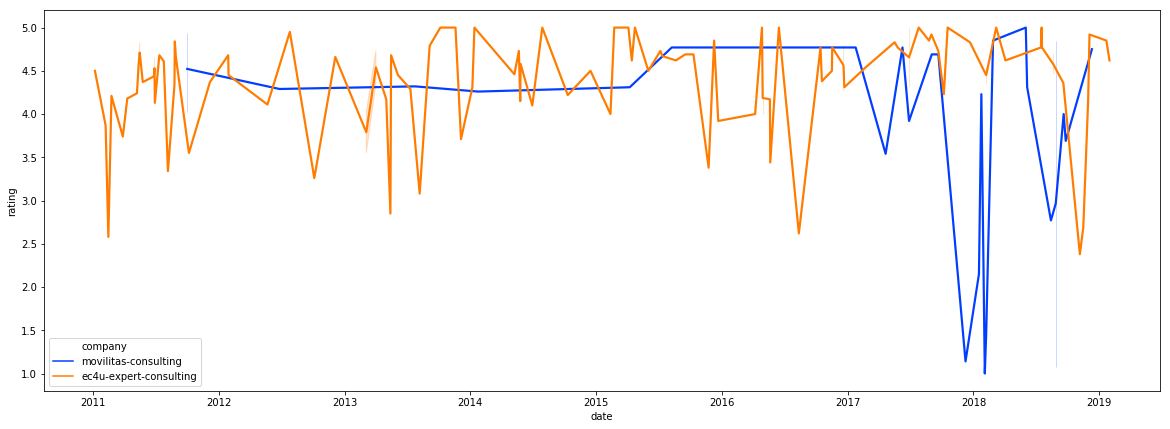

In [6]:
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 7) # set all figures to be size (width, height)
sns.lineplot(data = df , x="date", y="rating",
             hue = 'company',
             palette=sns.color_palette('bright', n_colors=2),
             linewidth=2.2)

### Histogram ratings 2011 - present

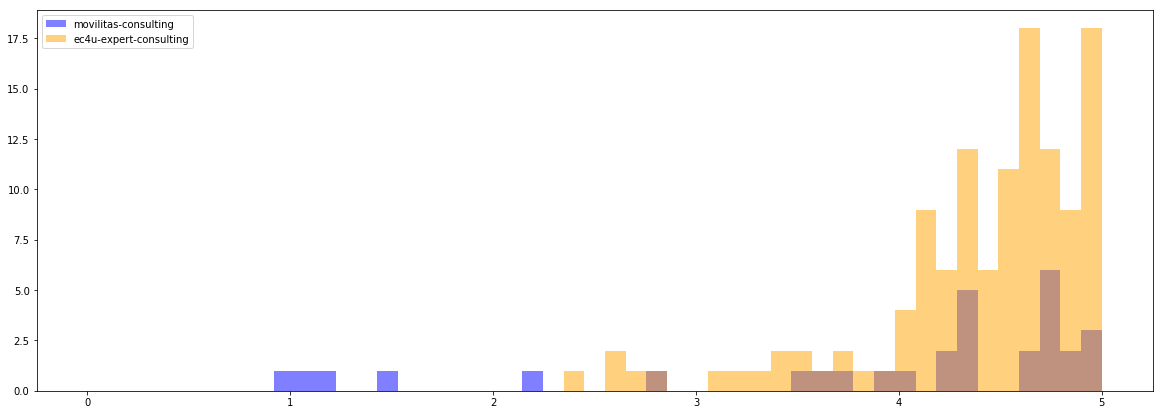

In [10]:
import random
import numpy
from matplotlib import pyplot

mov = df[df['company_id']==3]
ec4u = df[df['company_id']==2]
x = mov.rating
y = ec4u.rating

bins = numpy.linspace(-0, 5)

pyplot.hist(x, bins, alpha=0.5, label='movilitas-consulting', color = 'blue')
pyplot.hist(y, bins, alpha=0.5, label='ec4u-expert-consulting', color = 'orange')
pyplot.legend(loc='upper left')
pyplot.show()

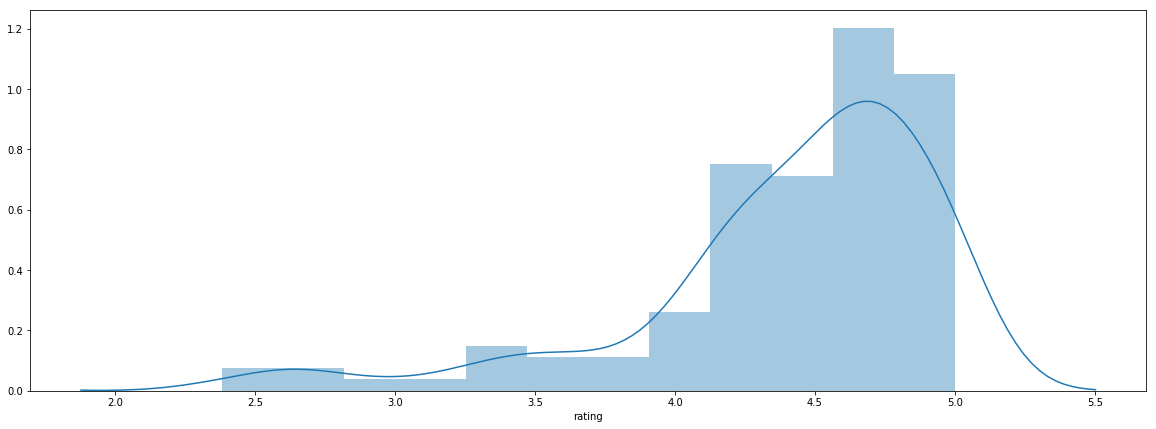

In [12]:
# ec4u-expert-consulting
sns.distplot(df[df['company_id']==2].rating)

In [13]:
df['year'], df['month'] = df['date'].dt.year, df['date'].dt.month
df.head(3)
mydict = {'rating': ['min', 'mean', 'max', 'count']}
df.groupby(by=['year', 'company']).agg(mydict)

rating                      
                               min      mean   max count
year company                                            
2011 ec4u-expert-consulting   2.58  4.289630  4.84    27
     movilitas-consulting     3.61  4.522000  5.00     5
2012 ec4u-expert-consulting   3.26  4.351667  4.95     6
     movilitas-consulting     4.29  4.290000  4.29     1
2013 ec4u-expert-consulting   2.85  4.191429  5.00    14
     movilitas-consulting     4.32  4.320000  4.32     1
2014 ec4u-expert-consulting   4.10  4.505000  5.00    10
     movilitas-consulting     4.26  4.260000  4.26     1
2015 ec4u-expert-consulting   3.38  4.547857  5.00    14
     movilitas-consulting     4.31  4.616667  4.77     3
2016 ec4u-expert-consulting   2.62  4.374348  5.00    23
2017 ec4u-expert-consulting   4.23  4.750833  5.00    12
     movilitas-consulting     1.14  3.931429  4.77     7
2018 ec4u-expert-consulting   2.38  4.336429  5.00    14
     movilitas-consulting     1.00  3.395385  5.00    13
2019 ec4u-expert-consulting   4.62  4.735000  4.85     2

#### To do: Possible Ideas to compare company reviews

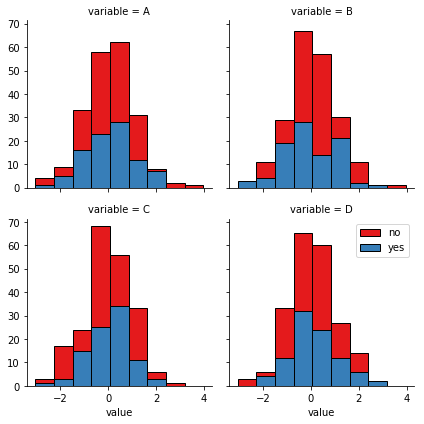

In [14]:
import numpy as np; np.random.seed(1)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(np.random.randn(300,4), columns=list("ABCD"))
df["group"] = np.random.choice(["yes", "no"], p=[0.32,0.68],size=300)

df2 = pd.melt(df, id_vars='group', value_vars=list("ABCD"), value_name='value')

bins=np.linspace(df2.value.min(), df2.value.max(), 10)
g = sns.FacetGrid(df2, col="variable", hue="group", palette="Set1", col_wrap=2)
g.map(plt.hist, 'value', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()